# Outline


- [Task 1](#task-1): Dimensionality Reduction and Regression with Convolutional Neural Networks - CNNs
 <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
- [Task 2](#task-2): Graph-based learning <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>

<a name="task-1"></a>

# Task 1: Dimensionality Reduction and Regression with Convolutional Neural Networks - CNNs [(index)](#index-task-1)

First, we import relevant packages and set up global configurations for matplotlib as well as setting the seed for rng and torch.

In [1]:
# Import relevant packages
import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
from torch.nn import Sequential, MSELoss, Conv2d, MaxPool2d, ConvTranspose2d, ReLU, Module, Flatten, Linear
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Fix random generator and torch seed for reproducibility
rng = np.random.default_rng(0)
torch.manual_seed(13)

# Imports used for testing.
import numpy.testing as npt

Now, we read in the data using pandas and reshape the samples into the desired shapes: $10 \times 10$ 2-dimensional matrices. Then, we split the samples into the training, validations and test sets.

In [2]:
# Dataset upload
dataset = pd.read_csv("gene_expression_transcriptomic_data.csv")

# Extract the first 100 features of the data and reshape each sample to a 10 x 10 2-dimnesional matrix
data = dataset.values[:, :100].reshape(-1, 10, 10)
data = np.expand_dims(data, axis=1)

# Split the samples into training, validation and test sets
Ntrain, Nval, Ntest = 1848, 264, 529
data_train, data_val, data_test = data[:Ntrain], data[Ntrain:Ntrain+Nval], data[Ntrain+Nval:]

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In the first part of this section, we build the CNN autoencoder in PyTorch composed of an encoder with:

* A `Conv2d` layer with 8 filters, kernel shape of (3, 3), a `ReLU` activation function and padding = 1
* A `MaxPool2d` layer with a pooling window size of (2,2) and a stride of 2
* Another `Conv2d` layer with 8 filters, kernel shape of (3, 3), a `ReLU` activation function and padding = 1,

and a decoder with:

* A `ConvTranspose2d` layer with 1 filter, kernel shape of (3, 3), a `ReLU` activation function, padding = 1, stride = 2 and output_padding = 1.

The code below builds this model, and sets the optimiser as `Adam` with learning rate = 0.001 and the criterion as `MSELoss`. We also define the `EarlyStopping` class from the CNN notebook and modify the `training_loop` function from the same notebook to define the function `train_autoencoder` that will be used to train our autoencoder.

In [3]:
# Define the encoder
encoder = Sequential(
    Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1),
    ReLU(),
    MaxPool2d(kernel_size=(2, 2), stride=2),
    Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1),
    ReLU()
)
        
# Define the decoder with output_padding=1 to ensure output is of the desired 10x10 shape
decoder = Sequential(
    ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
    ReLU()
)

# Instantiate the model, define the loss function and the optimiser
model = Sequential(encoder, decoder)
criterion = MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the EarlyStopping class from the CNN notebook
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
        max_patience (int): Amount of epochs with no improvement after which training is stopped.
        patience (int): Stores the number of epochs with no improvement.
        best_valid_loss (float): Stores the current value of the best (minimum) validation loss.
        early_stop (bool) True if training needs to be stopped due to the early stopping condition being met.

    Methods:
        step(val_loss):
            Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:
            self.best_valid_loss = val_loss
            self.patience = 0
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

# Define the `train_autoencoder` function, a modified version of `training_loop` from the CNN notebook
def train_autoencoder(train_loader, val_loader, model, criterion, optimiser, max_num_epochs=100, max_patience=5):
    history = {'training_loss': [], 'validation_loss': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs in train_loader:
            optimiser.zero_grad()
            outputs = model(inputs[0])
            loss = criterion(outputs, inputs[0])
            tr_loss += loss.item()
            loss.backward()
            optimiser.step()

        history['training_loss'].append(tr_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs_v in val_loader:
                outputs_v = model(inputs_v[0])
                loss_v = criterion(outputs_v, inputs_v[0])
                val_loss += loss_v.item()
                
        history['validation_loss'].append(val_loss / len(val_loader))

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{max_num_epochs}, Training Loss: {tr_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}')

        # Early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            break

    return history

We now create DataLoader objects of our training, validation and test data, with batch sizes of 32, to be used with our PyTorch model and use `train_autoencoder` to train our CNN autoencoder, using the $\mathrm{MSE}_{\mathrm{reconstruct}}$ loss as our metric, for a maximum of 100 epochs with max_patience = 5.

In [4]:
# Create tensors of the training, validation and test sets
data_train_tensor = torch.tensor(data_train, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test, dtype=torch.float32)

# Create DataLoader objects
train_loader = DataLoader(TensorDataset(data_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(data_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(data_test_tensor), batch_size=32, shuffle=False)

# Train the autoencoder using `train_autoencoder`
history = train_autoencoder(train_loader, val_loader, model, criterion, optimiser)

Epoch 1/100, Training Loss: 2.347121834754944, Validation Loss: 1.4842502276102703
Epoch 5/100, Training Loss: 0.9772680021565536, Validation Loss: 0.9418885906537374
Epoch 10/100, Training Loss: 0.8425566739049452, Validation Loss: 0.8232749236954583
Epoch 15/100, Training Loss: 0.7775234312846743, Validation Loss: 0.7737194101015726
Epoch 20/100, Training Loss: 0.758604472053462, Validation Loss: 0.7558371358447604
Epoch 25/100, Training Loss: 0.7466671549040695, Validation Loss: 0.7431693341996934
Epoch 30/100, Training Loss: 0.7378740177072328, Validation Loss: 0.7340693407588534
Epoch 35/100, Training Loss: 0.7322381149078238, Validation Loss: 0.7290684978167216
Epoch 40/100, Training Loss: 0.7281526604603077, Validation Loss: 0.7255964676539103
Epoch 45/100, Training Loss: 0.725306145076094, Validation Loss: 0.7231389151679145
Epoch 50/100, Training Loss: 0.7234042286872864, Validation Loss: 0.7206566267543368
Epoch 55/100, Training Loss: 0.7212548553943634, Validation Loss: 0.71

After training out CNN autoencoder, we plot the values of the $\mathrm{MSE}_{\mathrm{reconstruct}}$ loss on the training and validation sets against the number of epochs. Since there was no early stopping, we do not mark any values of number of epochs.

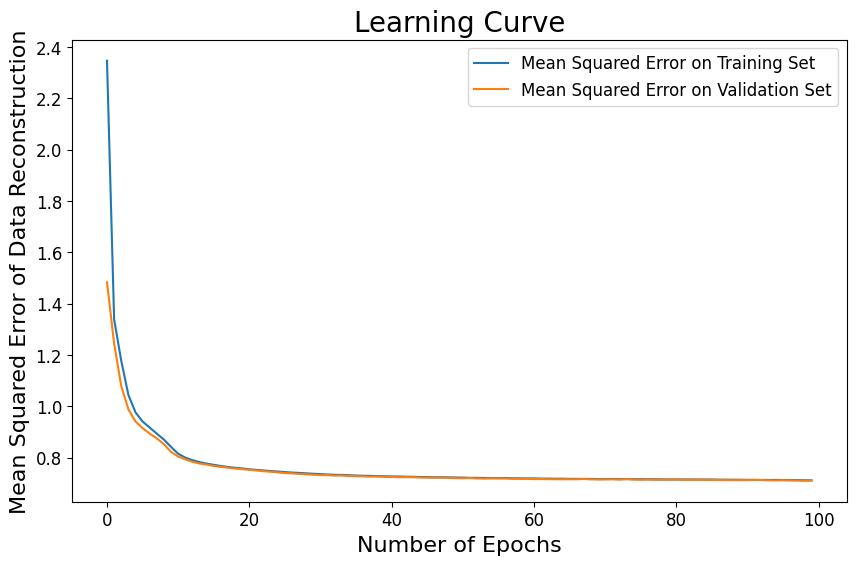

In [18]:
# Plot the training and validation losses against the number of epochs
plt.figure(figsize=(10, 6))
plt.plot(history['training_loss'], label='Mean Squared Error on Training Set')
plt.plot(history['validation_loss'], label='Mean Squared Error on Validation Set')
plt.title('Learning Curve', fontsize=20)
plt.xlabel('Number of Epochs', fontsize=16)
plt.ylabel('Mean Squared Error of Data Reconstruction', fontsize=16)
plt.legend(fontsize=12)
plt.show()

We compute the test-set per-feature reconstruction error $\mathrm{MSE}_{\mathrm{reconstruct}}^p$ and plot it on a $10 \times 10$ heatmap for visualisation.

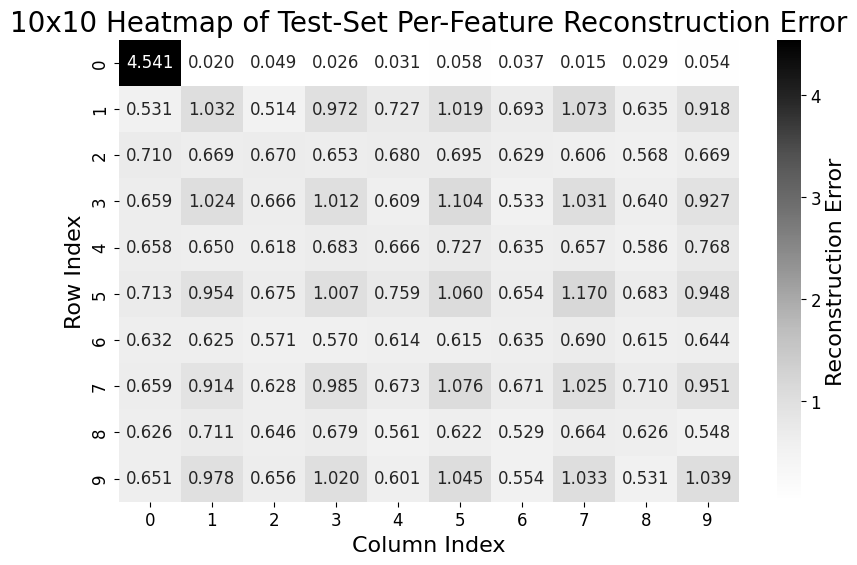

In [6]:
# Generate reconstructions on the test set
model.eval()
preds_test = model(data_test_tensor).detach().numpy()

# Compute per-feature reconstruction error
MSE_loss_p = np.mean((data_test - preds_test) ** 2, axis=0).squeeze()

# Plot heatmap using seaborn for better visualisation
plt.figure(figsize=(10, 6))
sns.heatmap(MSE_loss_p, annot=True, fmt='.3f', cmap='Greys', cbar_kws={'label': 'Reconstruction Error'})
plt.xlabel('Column Index', fontsize=16)
plt.ylabel('Row Index', fontsize=16)
plt.title('10x10 Heatmap of Test-Set Per-Feature Reconstruction Error', fontsize=20)
plt.show()

From the above heatmap, we see that the per-feature reconstruction error on the test set is generally quite small with the majority of values between $0.5$ and $0.7$. There are some deviations from this general range, as we see that features that have both odd column and odd row indices have greater reconstruction errors that are around $1$. Also, we see that the row with index 0 completely differs from the patterns we see elsewhere as all of the errors are much smaller at around $0.05$ or less other than the error in the column with index 0, that has a much larger error at over $4.5$. We can try to understand these patterns and observations by considering the architecture of the CNN autoencoder. The checkered pattern, in which the errors of features with odd column and row indices are greater, likely stems from a combination of the max-pooling layer, that had a window shape of (2, 2) and stride 2 halving the spatial dimensions, and the transposed convolutional layer, which upsamples the encoded data. Both of these layers may ultimately affect the reconstruction of features with odd row and column indices differently to other features, hence we observe increased errors for these features. By inspecting the values of the features in row 0 and comparing them with the values of other features, we see that there are some obvious differences. Most features have mainly positive values and when there are negative values they are usually of small magnitude, whereas it appears all values of the first feature are negative and have larger magnitudes than the negative values of other features. Since the ReLU activation function only outputs non-negative values and there is a ReLU activation function after the transposed convolutional layer, the reconstructed value for the first feature will always be non-negative. This causes the model to be unable to reconstruct this feature well, and causes it to have a much larger reconstruction error. In contrast, the other features in row 0 all have positive values and comparing their values to the values of other features, we see that generally they are much less varied with most samples having very similar values. This allows the model to be able to reconstruct these features well as even a mean of these values would have a low reconstruction error.

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

To compute the dimensions of the encoder's output, we consider the shape of the input and then the shape the outputs of each layer. The input is the $10 \times 10$ matrix with a single channel hence it has shape $(1, 10, 10)$. The output following the first 2-dimensional convolutional layer is a tensor of the shape $(8, 10, 10)$ as the convolutional layer has $8$ channels out, and retains the same shape in each channel due to the padding. This can be seen from the formula for $l_{\mathrm{out}}$, the height (or width) of each channel of the output, as it is $l_{\mathrm{out}}=\left\lfloor\frac{l_{\mathrm{in}}+2\times\mathrm{padding}-\mathrm{kernel\_size}}{\mathrm{stride}}+1\right\rfloor$, where $l_{\mathrm{in}}$ is the height (or width) of each channel of the input. Hence, we see that $l_{\mathrm{out}} = \left\lfloor \frac{10 + 2 \times 1 - 3}{1} + 1 \right\rfloor = 10$ for both the height and width. The max-pooling layer thus takes a tensor of the shape $(8, 10, 10)$ as its input and using the same formula, we see that its output will be of the shape $(8, 5, 5)$ as it has $8$ channels out and $l_{\mathrm{out}} = \left\lfloor \frac{10 + 2 \times 1 - 2}{2} + 1 \right\rfloor = 5$ for both the height and width. Finally, we see that the second 2-dimensional convolutional layer will output a tensor of the shape $(8, 5, 5)$ as it has $8$ channels out and $l_{\mathrm{out}} = \left\lfloor \frac{5 + 2 \times 1 - 3}{1} + 1 \right\rfloor = 5$ for both the height and width. So, the dimensions of the output of the encoder are $(8, 5, 5)$.

Now, to visualise these lower-dimensional representations for the data points in the test set we plot the elements with indices [1, 0, 1] against the ones with indices [0, 0, 0] with the colour of each point representing their corresponding value of the target variable MAP7.

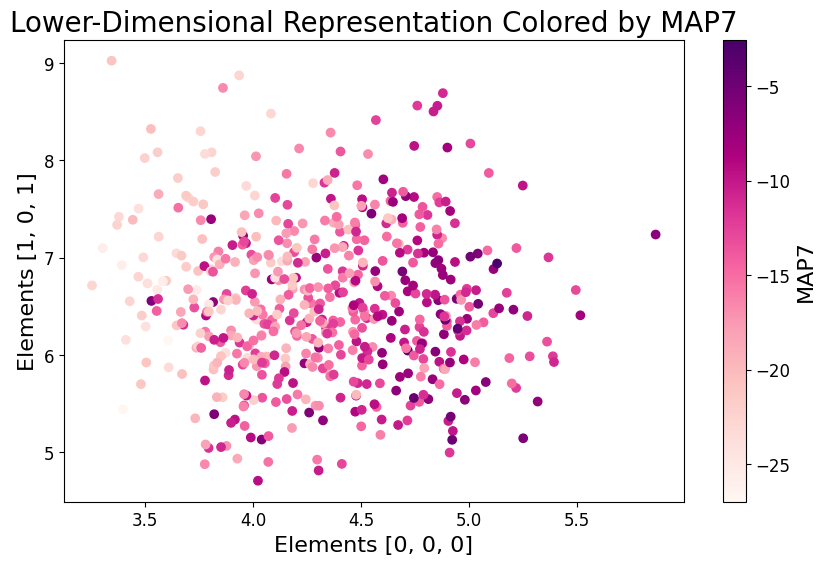

In [7]:
# Coompute the encodede lower-dimensional representations for the data points in the test set
encoder.eval()
with torch.no_grad():
    encoded_test = encoder(data_test_tensor).numpy()

# Extract elements with indices [1, 0, 1] and [0, 0, 0]
element_101 = encoded_test[:, 1, 0, 1]
element_000 = encoded_test[:, 0, 0, 0] 

# Extract the data for the target regression variable MAP7
MAP7_data = dataset.values[:, 100]
MAP7_train, MAP7_val, MAP7_test = MAP7_data[:Ntrain], MAP7_data[Ntrain:Ntrain+Nval], MAP7_data[Ntrain+Nval:]

# Plot the elements, colored by MAP7
plt.figure(figsize=(10, 6))
plt.scatter(element_000, element_101, c=MAP7_test, cmap='RdPu')
plt.colorbar(label='MAP7')
plt.xlabel('Elements [0, 0, 0]', fontsize=16)
plt.ylabel('Elements [1, 0, 1]', fontsize=16)
plt.title('Lower-Dimensional Representation Colored by MAP7', fontsize=20)
plt.show()

From the above plot of the values of the elements with indices [1, 0, 1] against the ones with indices [0, 0, 0], we cannot see any clear correlation between the two elements however there does appear to be a pattern between the elements with indices [0, 0, 0] and the corresponding values of the target variable MAP7. There is clearly some positive correlation between the value of the element with indices [0, 0, 0] and the value of the target variable MAP7: for higher values of the element with indices [0, 0, 0] there are higher values of the target variable MAP7 and for lower values of the element with indices [0, 0, 0] there are lower values of the target variable MAP7. This could imply that the element with indices [0, 0, 0] contains information from a number of other features that are closely tied to the target variable MAP7, hence it likely contains information about the levels of expression for genes that are either complementary or opposing to the MAP7 gene. The same cannot be said for the element with indices [1, 0, 1] as across all values of the element, a wide range of values of the MAP7 variable can be seen and there does not appear to be any correlation.

Next, we use the encoder’s lower-dimensional representation to build a regressor, which takes the encoder’s output as its input and predicts the target regression variable MAP7. The regressor consists of:

* A `Flatten` layer flattening the encoder's output
* A `Linear` layer with one output unit.

In the code below, we first freeze the encoder's parameters and then build the regressor model. We then set the optimiser as `Adam` with learning rate = 0.001 and set the criterion as `MSELoss`. We modify the `training_loop` function from the CNN notebook once again to define the function `train_regressor` that will be used to train our regressor.

In [8]:
# Freeze the encoder
for param in encoder.parameters():
    param.requires_grad = False

# Define the regressor, loss function and optimiser
regressor = Sequential(
    Flatten(),
    Linear(8 * 5 * 5, 1)
)
criterion = MSELoss()
optimiser = torch.optim.Adam(regressor.parameters(), lr=0.001)

# Define the `train_regressor` function, modified from the `training_loop` function from the CNN notebook,
# similarly to `train_autoencoder`
def train_regressor(train_loader, val_loader, regressor, criterion, optimiser, max_num_epochs=1000, max_patience=10):
    history = {'training_loss': [], 'validation_loss': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):
        
        tr_loss = 0.0
        val_loss = 0.0
        
        # Training
        regressor.train()
        for inputs, trues in train_loader:
            optimiser.zero_grad()
            encoded = encoder(inputs)  # Use encoder's output
            outputs = regressor(encoded).squeeze()
            loss = criterion(outputs, trues)
            tr_loss += loss.item()
            loss.backward()
            optimiser.step()

        history['training_loss'].append(tr_loss / len(train_loader))

        # Validation
        regressor.eval()
        with torch.no_grad():
            for inputs_v, trues_v in val_loader:
                encoded_v = encoder(inputs_v)  # Use encoder's output
                outputs_v = regressor(encoded_v).squeeze()
                loss_v = criterion(outputs_v, trues_v)
                val_loss += loss_v.item()
                
        history['validation_loss'].append(val_loss / len(val_loader))

        # Print progress
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{max_num_epochs}, Training Loss: {tr_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}')

        # Early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            break

    return history

Then, we create DataLoader objects of our training, validation and test data including the MAP7 target regression variable, with batch sizes of 32, to be used with our PyTorch model and use `train_regressor` to train our regressor, using the $\mathrm{MSE}_{\mathrm{regress}}$ loss as our metric, for a maximum of 1000 epochs with max_patience = 10.

In [9]:
# Create tensors of the MAP7 data
MAP7_train_tensor = torch.tensor(MAP7_train, dtype=torch.float32)
MAP7_val_tensor = torch.tensor(MAP7_val, dtype=torch.float32)
MAP7_test_tensor = torch.tensor(MAP7_test, dtype=torch.float32)

# Create DataLoader objects including the MAP7 data
train_loader_reg = DataLoader(TensorDataset(data_train_tensor, MAP7_train_tensor), batch_size=32, shuffle=True)
val_loader_reg = DataLoader(TensorDataset(data_val_tensor, MAP7_val_tensor), batch_size=32, shuffle=False)
test_loader_reg = DataLoader(TensorDataset(data_test_tensor, MAP7_test_tensor), batch_size=32, shuffle=False)

# Train the regressor
history_reg = train_regressor(train_loader_reg, val_loader_reg, regressor, criterion, optimiser)

Epoch 1/1000, Training Loss: 56.07729650365895, Validation Loss: 27.073413213094074
Epoch 50/1000, Training Loss: 11.332110980461383, Validation Loss: 11.164079560173882
Epoch 100/1000, Training Loss: 9.234048942039752, Validation Loss: 9.969148794809977
Epoch 150/1000, Training Loss: 8.602787774184655, Validation Loss: 9.055009577009413
Epoch 200/1000, Training Loss: 8.240968342485099, Validation Loss: 8.86040253109402
Early stopping triggered at epoch 241.


We see that early stopping was triggered at epoch 241, and now define the function `r2_score` to compute the $R^2$ score of the regressor to assess its performance.

In [10]:
# Computes the R^2 score to assess regression performance
def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""
    y_bar = np.mean(y)

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

# Evaluate on the training and test set
regressor.eval()
with torch.no_grad():
    encoded_train = encoder(data_train_tensor)
    encoded_test = encoder(data_test_tensor)
    preds_train_MAP7 = regressor(encoded_train).squeeze().numpy()
    preds_test_MAP7 = regressor(encoded_test).squeeze().numpy()

# Compute and print R^2 score on both training and test sets
r2_train = r2_score(MAP7_train, preds_train_MAP7)
r2_test = r2_score(MAP7_test, preds_test_MAP7)
print(f'R2 Score on Training Set: {r2_train:.3f}')
print(f'R2 Score on Test Set: {r2_test:.3f}')

R2 Score on Training Set: 0.676
R2 Score on Test Set: 0.661


We see that the regressor obtained an $R^2$ score of $0.661$ on the test data and $0.676$ on the training data. This shows that the regressor is able to explain $67.6$% of the variance in the MAP7 variable on the training set and $66.1$% of the variance on the test set and is considerably better than just using the mean as an estimate. Since the scores are close and the score on the test data is only slightly lower than the score on the training data, we see there is minimal overfitting to the training data. Overall, we see that the regressor performs moderately well on the unseen test data and only slightly overfits to the training data, if at all.

<a name="task-2"></a>

# Task 2: Graph-based learning [(index)](#index-task-2)

To start this task, we first need to extract the first 400 rows and first 10 columns of the data, and store it in the matrix $X$.

In [11]:
# Extract first 10 columns of the first 400 samples of the data
X = dataset.iloc[:400, :10].values # extract the first 400 rows and 10 columns
treatment = dataset.iloc[:, 101].values[:400, ] # extract the corresponding 400 treatment labels

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

Now we have this data in the matrix $X$, we compute the $400 \times 400$ matrix $S$ of cosine similarities. Using the definitions of $A^{(\delta)}$ and $G^{(\delta)}$, we then define the functions `n_delta` and `s_delta` to compute $n(\delta)$ and $s(\delta)$ of the sparsified graph $G^{(\delta)}$, given $A^{(\delta)}$. Using these functions, we compute $n(\delta)$ and $s(\delta)$ for 200 values of $\delta$ ranging equidistantly from [$\mathrm{min}(S)$, $\mathrm{max}(S)$]. We then plot these values of $n(\delta)$ and $s(\delta)$ against the values of $\delta$ in two subplots and mark the value of $\delta$*, which we define as the largest threshold $\delta$ $\in$ [$\mathrm{min}(S)$, $\mathrm{max}(S)$] that keeps the graph entirely connected, on each subplot.

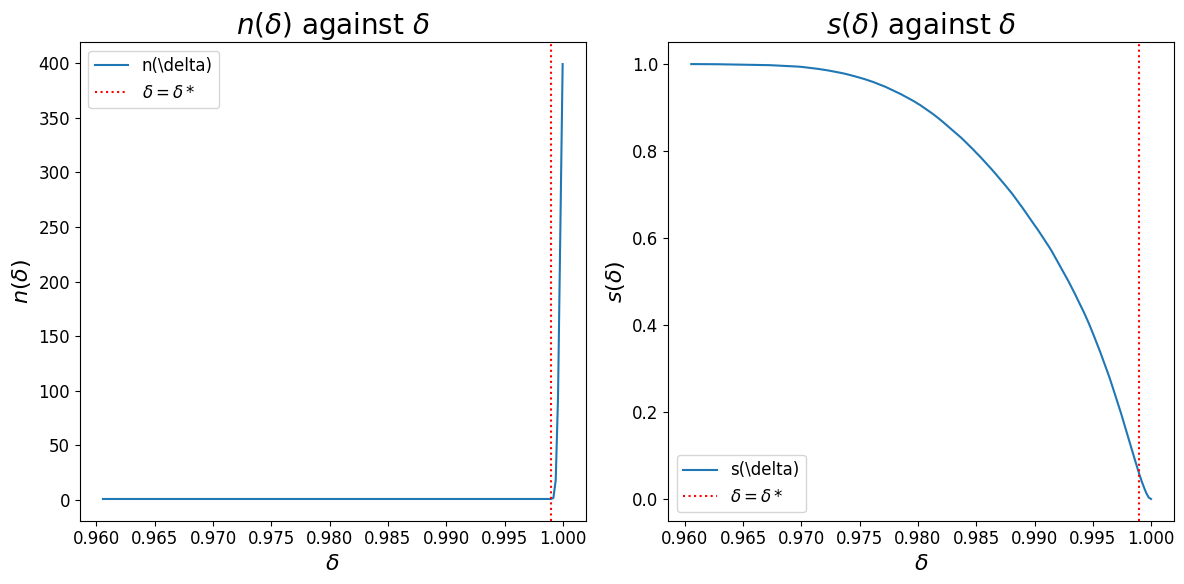

In [12]:
# Compute the matrix S of cosine similarities and set all values on the diagonal to 0 so the matrix
# can be interpreted as the adjacency matrix of a dense, weighted graph
X_norms = np.linalg.norm(X, axis=1, keepdims=True)
X_norm = X / X_norms
S = np.dot(X_norm, X_norm.T)
np.fill_diagonal(S, 0)

# Compute the values of min(S) and max(S) and create an array of 200 deltas ranging equidistantly
# min(S) to max(S)
S_min, S_max = np.min(S[S > 0]), np.max(S)
deltas = np.linspace(S_min, S_max, 200)

# Define n_delta to compute the number of connected components in a graph with adjacency matrix
# A_delta using the fact the number of 0 eigenvalues of L is the number of connected components
def n_delta(A_delta):
    d = A_delta.sum(axis=0)
    D = np.diag(d)
    L = D - A_delta
    eigenvals, eigenvecs = np.linalg.eigh(L)
    return (np.sum(np.abs(eigenvals) < 1e-8))

# Define s_delta to compute the sparsity level of the graph with ajacency matrix A_delta
def s_delta(A_delta):
    N = len(A_delta)
    return (np.count_nonzero(A_delta > 0)/2) / (N*(N-1)/2)

# Initialise the lists n_list and s_list and populate them with the values of n_delta and s_delta 
# respectively for each value of delta in the array deltas
n_list, s_list = [], []
for delta in deltas:
    A_delta = np.copy(S)
    A_delta[A_delta < delta] = 0
    n_list.append(n_delta(A_delta))
    s_list.append(s_delta(A_delta))

# Set delta_star equal to the largest threshold delta in the deltas array such that the graph is
# entirely connected
last_index = len(n_list) - 1 - n_list[::-1].index(1)
delta_star = deltas[last_index]

# Plot n_list and s_list against the values in the deltas array and mark delta_star in each subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(deltas, n_list, label='n(\delta)')
axs[0].axvline(x=delta_star, color='red', linestyle='dotted', label='$\delta = \delta *$')
axs[0].set_title('$n(\delta)$ against $\delta$', fontsize=20)
axs[0].set_xlabel('$\delta$', fontsize=16)
axs[0].set_ylabel('$n(\delta)$', fontsize=16)
axs[0].legend(loc=2, fontsize=12)

axs[1].plot(deltas, s_list, label='s(\delta)')
axs[1].axvline(x=delta_star, color='red', linestyle='dotted', label='$\delta = \delta *$')
axs[1].set_title('$s(\delta)$ against $\delta$', fontsize=20)
axs[1].set_xlabel('$\delta$', fontsize=16)
axs[1].set_ylabel('$s(\delta)$', fontsize=16)
axs[1].legend(loc=3, fontsize=12)

plt.tight_layout()
plt.show()

Now, we report the sparsity level of the final sparsified graph defined as $G := G^{(\delta \text{*})}$.

In [13]:
# Compute the adjacency matrix of the final sparsified graph
A_delta_star = np.copy(S)
A_delta_star[A_delta_star < delta_star] = 0

# Compute and print the sparsity level of the final sparsified graph
print(f'Sparsity level of G: {s_delta(A_delta_star):.4f}')

Sparsity level of G: 0.0557


Finally, we visualise the graph $G$ using the spectral layout introduced in the Graphs notebook, defining and using the `plot_graph` function from the notebook.

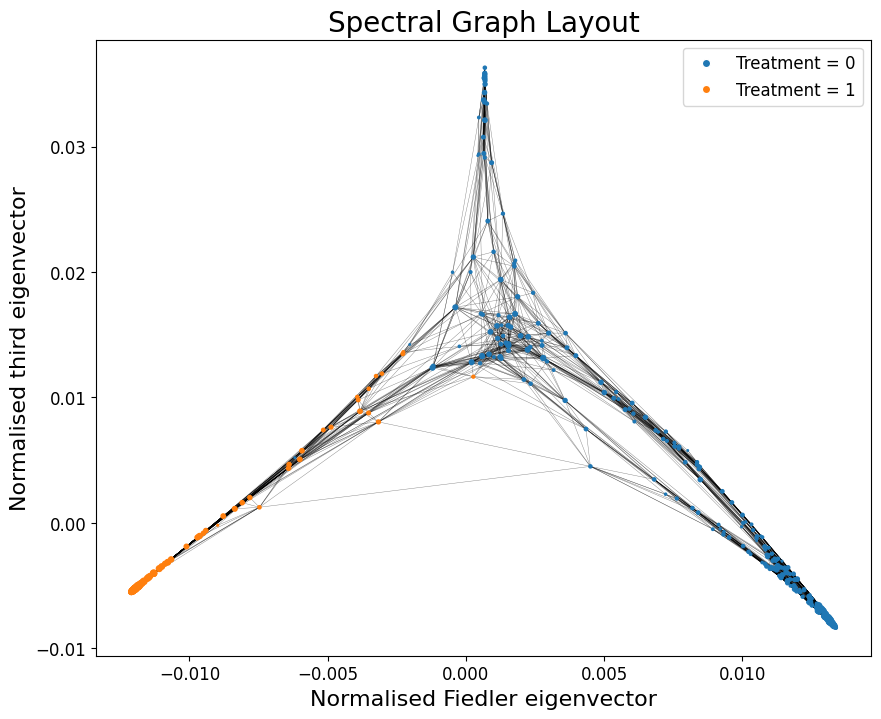

In [14]:
# Define cmap as the colourmap 'tab10'
cmap = matplotlib.colormaps.get_cmap('tab10')
color_type = [cmap(i) for i in dataset.iloc[:400, 101].values]

# Compute the symmetric normalised graph Laplacian L_s
d = A_delta_star.sum(axis=0)
D = np.diag(d)
L = D - A_delta_star
D_sqrt_inv = np.diag(1/np.sqrt(d))
L_s = D_sqrt_inv @ L @ D_sqrt_inv

# Compute eigen decomposition using the fact that L_s is symmetric
eigenvals, eigenvecs = np.linalg.eigh(L_s)
eigenvecs = eigenvecs.T

# Get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]
v3 = eigenvecs[2]

# Normalise coordinates
x = D_sqrt_inv @ v2
y = D_sqrt_inv @ v3

# Define plot_graph from the Graphs notebook
def plot_graph(adjacency, x_coord, y_coord, node_size, node_color):
    """Plot undirected graph.

    Parameters:
        adjacency (np.array): N x N adjacency matrix.
        x_coord (np.array): X-coordinates for N nodes.
        y_coord (np.array): Y-coordinates for N nodes.
        node_size (np.array): Size for each of the N nodes.
        node_color (np.array): Color for each of the N nodes.
    """

    # Set N equal to number of nodes
    N = adjacency.shape[0]

    # Plot
    fig, ax = plt.subplots(1, figsize=(10, 8))

    # Plot edges
    for i in range(N):
        for j in range(i+1,N):
            if adjacency[i,j] > 0:
                ax.plot([x_coord[i],x_coord[j]],[y_coord[i],y_coord[j]], color="black", alpha=0.5, linewidth=0.3)

    # Plot nodes
    scatter = ax.scatter(x_coord,y_coord,s=0.4*node_size, c=node_color, zorder=10)

    return ax

# Plot graph, set label and create the legend for node types
ax = plot_graph(adjacency=A_delta_star, x_coord=x, y_coord=y, node_size=d, node_color=color_type)
ax.set_xlabel("Normalised Fiedler eigenvector", fontsize=16)
ax.set_ylabel("Normalised third eigenvector", fontsize=16)
ax.set_title("Spectral Graph Layout", fontsize=20) 
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in {0: 'Treatment = 0', 1: 'Treatment = 1'}.items()]
plt.legend(handles=types_legend, fontsize=12);

Looking at the above plot, we see that the visualisation of the graph has 3 main arms with densely packed nodes as well as a less dense cluster at the centre of these arms. The majority of the nodes in the centre represent samples with treatment labels of 0, hence these cells were not subject to drug treatment. 2 of the 3 arms are also made up of samples with treatments labels of 0, with the other arm being made up of samples with treatment labels of 1, meaning these cells were subject to drug treatment. From an initial inspection, we can conclude that the samples with treatment labels of 0 are generally more spread out than those with treatment labels of 1 as not only are they spread over 2 arms and the central cluster, but even across these areas there is more separation between nodes and the nodes are typically smaller than the nodes representing samples with treatment labels of 1. The smaller size represents lower degrees in these nodes. This implies that the cells that were not subject to drug treatment were less similar to each other, in terms of the levels of expression of the first 10 genes in the dataset, than the cells that were treated with drugs. This is likely due to the fact that the drug treatment would have regulated these levels of gene expression so that there was less variance in these values for these cells when compared to cells that did not undergo any drug treatment.

We see that the sparsity level of this graph $G$ is $0.0557$ meaning that out of all of the possible edges between nodes, only $5.57$% are present in this graph. This means that the graph is rather sparse, and this is seen in the visualisation above, as the 3 arms are for the most part not directed connected, and the distance from the end of one arm to the end of another is quite large.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

Below, we compute the degree centralities of each node and plot the histograms of these centralities for the two different treatment label, using one colour for each treatment label.

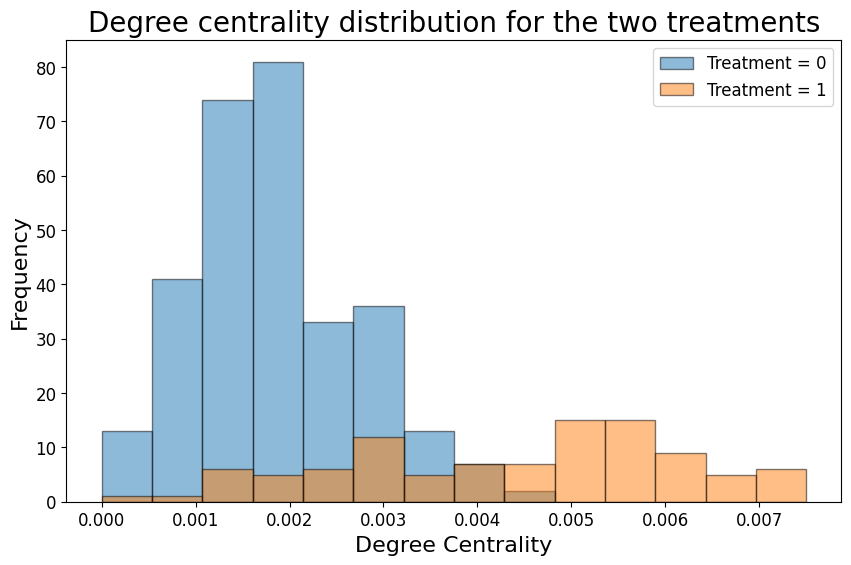

In [15]:
# Compute the degree centralities of each node by dividing the degrees by the sum of the degrees of all nodes
d_cent = d / np.sum(d)

# Set bins for the histogram to be from 0 to 0.0075 with widths of 0.0005
bins = np.linspace(0, 0.0075, 15)

# Plot the histograms of the degree centralities for the two different treatment labels
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.hist(d_cent[dataset.iloc[:400, 101].values==0], bins=bins, alpha=0.5, edgecolor='black', label=r"Treatment = 0")
ax.hist(d_cent[dataset.iloc[:400, 101].values==1], bins=bins, alpha=0.5, edgecolor='black', label=r"Treatment = 1")
ax.set_xlabel("Degree Centrality", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Degree centrality distribution for the two treatments", fontsize=20) 
ax.legend(fontsize=12)
plt.show()

Now, we report the mean degree for the 2 groups of samples.

In [16]:
# Compute and print the mean degree for the two groups of samples
d_mean_0 = np.mean(d[dataset.iloc[:400, 101].values==0])
d_mean_1 = np.mean(d[dataset.iloc[:400, 101].values==1])
print(f'Mean degree of samples with Treatment = 0: {d_mean_0:.2f}')
print(f'Mean degree of samples with Treatment = 1: {d_mean_1:.2f}')

Mean degree of samples with Treatment = 0: 16.63
Mean degree of samples with Treatment = 1: 38.91


From the above histograms, we see that the degree centrality distributions for the 2 groups of samples differ a lot. We see that for the group with treatment label 0, there is a tighter spread at lower degree centralities whereas the group with treatment label 1 has a wider, flatter spread with the majority of its samples at higher centralities. This is also seen in the mean degrees for the 2 groups as the mean degree for the group with treatment labels of 0 is lower at $16.63$ compared to the mean degree for the group with treatment labels of 1 at $38.91$. A possible explanation for this is similar to the reasonings discussed in [(2.1)](#task-21) as the higher degrees and degree centrailities are due to having greater cosine similarities with other samples, mainly with samples within the same group. Hence, more of the cells that were subject to drug treatment were similar enough to other cells in the same group, in terms of the gene expression levels, to have an edge between them, when compared to the cells that were not subject to drug treatment. This was likely a side effect of the intended purpose of the treatments, as if the purpose of the drug treatment was to affect the expression level of MAP7, in an attempt to prevent or treat several cancers, the 10 genes considered in producing the cosine similarities would also likely be affected as they are known to be most correlated to MAP7. This would in turn cause them to also be more regulated and have decreased variance, increasing the cosine similarities between cells undergoing the drug treatment.